In [2]:
from sqlalchemy import create_engine
from requests import Session
import pandas as pd

engine = create_engine('URI', 
                        connect_args={'http_session': Session()})
connection = engine.connect()

# Paper - Crypto API Users 

In [3]:
query1 = """
    
WITH crypto_asset AS (

    SELECT CAST(papertrader_replica.assets.id AS varchar(256)) AS id
    FROM papertrader_replica.assets
    WHERE papertrader_replica.assets.class = 'crypto'


), first_crypto_order AS (

    SELECT  DISTINCT papertrader_replica.orders.account, 
            DATE_TRUNC('week', papertrader_replica.orders.filled_at) AS filled_at_week, 
            MIN(DATE_TRUNC('week', papertrader_replica.orders.filled_at)) OVER (PARTITION BY papertrader_replica.orders.account ORDER BY DATE_TRUNC('week', filled_at)) AS first_order_week
    FROM papertrader_replica.orders
    JOIN crypto_asset ON crypto_asset.id = papertrader_replica.orders.asset_id 
    
    WHERE   papertrader_replica.orders.filled_at >= '2022-01-01'
    AND     papertrader_replica.orders.filled_at IS NOT NULL
    AND     papertrader_replica.orders.source = 'access_key'
)

SELECT  filled_at_week AS "timeframe",
        SUM(new_api_user) AS "New API Users",
        SUM(returning_api_user) AS "Returning API Users"
        
FROM ( 

        SELECT  DISTINCT
                filled_at_week,
                first_crypto_order.account,
                CASE WHEN first_order_week = DATE_TRUNC('week', papertrader_replica.orders.orders.filled_at) THEN 1 ELSE 0 END AS new_api_user,
                CASE WHEN first_order_week != DATE_TRUNC('week', papertrader_replica.orders.orders.filled_at) THEN 1 ELSE 0 END AS returning_api_user
        FROM    first_crypto_order
        JOIN    papertrader_replica.orders 
                    ON first_crypto_order.account = papertrader_replica.orders.account 
                    AND first_crypto_order.filled_at_week = DATE_TRUNC('week', papertrader_replica.orders.filled_at)
        JOIN    crypto_asset ON papertrader_replica.orders.orders.asset_id = crypto_asset.id
        WHERE   papertrader_replica.orders.filled_at >= '2022-01-01'
        AND     papertrader_replica.orders.filled_at IS NOT NULL
        AND     papertrader_replica.orders.source = 'access_key'

) subb

GROUP BY filled_at_week
    
    """


In [4]:
paper_api_crypto = pd.read_sql_query(query1, engine)

In [ ]:
paper_api_crypto = paper_api_crypto.sort_values(by=['timeframe']).drop(paper_api_crypto.index[0])
paper_api_crypto

In [1]:
paper_api_crypto['total'] = paper_api_crypto['New API Users'] + paper_api_crypto['Returning API Users']
paper_api_crypto['returning_to_total_rate'] = (paper_api_crypto['Returning API Users'] / paper_api_crypto['total']) * 100
paper_api_crypto['returning_to_total_rate'] = paper_api_crypto['returning_to_total_rate'].round(decimals=2)
paper_api_crypto

NameError: name 'paper_api_crypto' is not defined

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

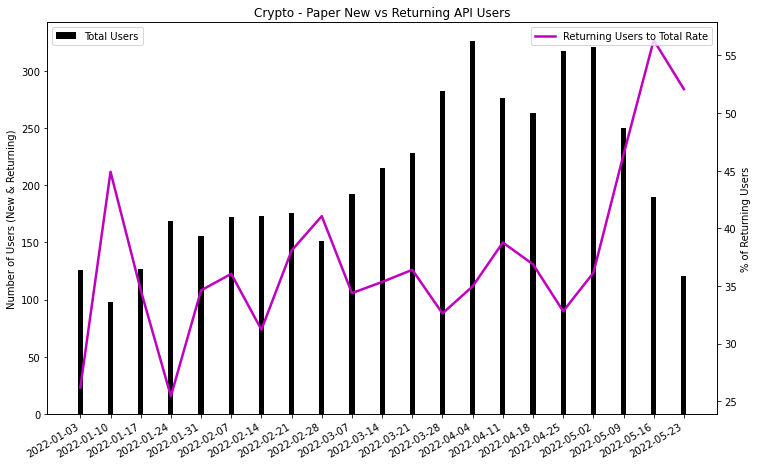

In [122]:
fig, ax1 = plt.subplots()

timeframe = paper_api_crypto['timeframe']
returning_total_rate = paper_api_crypto['returning_to_total_rate']
total_users = paper_api_crypto['total']

ax1.bar(timeframe, total_users, color = 'black', width = 1.2, label = 'Total Users')
ax2 = ax1.twinx()
ax2.plot(timeframe, returning_total_rate, '-m', linewidth = 2.5 ,label = 'Returning Users to Total Rate')

ax1.set_ylabel('Number of Users (New & Returning)')
ax2.set_ylabel('% of Returning Users')
plt.title('Crypto - Paper New vs Returning API Users')
ax2.legend(loc="upper right")
ax1.legend(loc="upper left")

plt.xticks(timeframe, rotation = 90)

plt.gcf().autofmt_xdate()
plt.show()

# Paper - Equity API Users 

In [30]:
query2 = """
    
WITH equity_asset AS (

    SELECT CAST(papertrader_replica.assets.id AS varchar(256)) AS id
    FROM papertrader_replica.assets
    WHERE papertrader_replica.assets.class != 'crypto'


), first_equity_order AS (

    SELECT  DISTINCT papertrader_replica.orders.account, 
            DATE_TRUNC('week', papertrader_replica.orders.filled_at) AS filled_at_week, 
            MIN(DATE_TRUNC('week', papertrader_replica.orders.filled_at)) OVER (PARTITION BY papertrader_replica.orders.account ORDER BY DATE_TRUNC('week', filled_at)) AS first_order_week
    FROM papertrader_replica.orders
    JOIN equity_asset ON equity_asset.id = papertrader_replica.orders.asset_id 
    
    WHERE   papertrader_replica.orders.filled_at >= '2022-01-01'
    AND     papertrader_replica.orders.filled_at IS NOT NULL
    AND     papertrader_replica.orders.source = 'access_key'
)

SELECT  filled_at_week AS "timeframe",
        SUM(new_api_user) AS "New API Users",
        SUM(returning_api_user) AS "Returning API Users"
        
FROM ( 

        SELECT  DISTINCT
                filled_at_week,
                first_equity_order.account,
                CASE WHEN first_order_week = DATE_TRUNC('week', papertrader_replica.orders.orders.filled_at) THEN 1 ELSE 0 END AS new_api_user,
                CASE WHEN first_order_week != DATE_TRUNC('week', papertrader_replica.orders.orders.filled_at) THEN 1 ELSE 0 END AS returning_api_user
        FROM    first_equity_order
        JOIN    papertrader_replica.orders 
                    ON first_equity_order.account = papertrader_replica.orders.account 
                    AND first_equity_order.filled_at_week = DATE_TRUNC('week', papertrader_replica.orders.filled_at)
        JOIN    equity_asset ON papertrader_replica.orders.orders.asset_id = equity_asset.id
        WHERE   papertrader_replica.orders.filled_at >= '2022-01-01'
        AND     papertrader_replica.orders.filled_at IS NOT NULL
        AND     papertrader_replica.orders.source = 'access_key'

) subb

GROUP BY filled_at_week
    
    """


In [31]:
paper_api_equity = pd.read_sql_query(query2, engine)

In [115]:
paper_api_equity = paper_api_equity.sort_values(by=['timeframe']).drop(paper_api_equity.index[0])
paper_api_equity

,timeframe,New API Users,Returning API Users
1,2022-01-10,716,1059
2,2022-01-17,633,1115
3,2022-01-24,839,1146
4,2022-01-31,738,1225
5,2022-02-07,693,1177
6,2022-02-14,628,1157
7,2022-02-21,519,1162
8,2022-02-28,586,1237
9,2022-03-07,611,1182
10,2022-03-14,627,1176


In [116]:
paper_api_equity['total'] = paper_api_equity['New API Users'] + paper_api_equity['Returning API Users']
paper_api_equity['returning_to_total_rate'] = (paper_api_equity['Returning API Users'] / paper_api_equity['total']) * 100
paper_api_equity['returning_to_total_rate'] = paper_api_equity['returning_to_total_rate'].round(decimals=2)
paper_api_equity

,timeframe,New API Users,Returning API Users,total,returning_to_total_rate
1,2022-01-10,716,1059,1775,59.66
2,2022-01-17,633,1115,1748,63.79
3,2022-01-24,839,1146,1985,57.73
4,2022-01-31,738,1225,1963,62.40
5,2022-02-07,693,1177,1870,62.94
6,2022-02-14,628,1157,1785,64.82
7,2022-02-21,519,1162,1681,69.13
8,2022-02-28,586,1237,1823,67.86
9,2022-03-07,611,1182,1793,65.92
10,2022-03-14,627,1176,1803,65.22


In [117]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

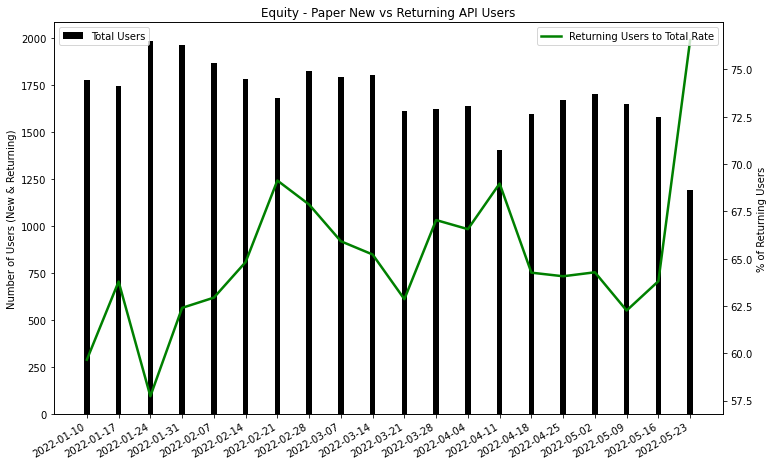

In [125]:
fig, ax1 = plt.subplots()

timeframe_2 = paper_api_equity['timeframe']
returning_total_rate_2 = paper_api_equity['returning_to_total_rate']
total_users_2 = paper_api_equity['total']

ax1.bar(timeframe_2, total_users_2, width = 1.2, color = 'black', label = 'Total Users')
ax2 = ax1.twinx()
ax2.plot(timeframe_2, returning_total_rate_2, '-g', label = 'Returning Users to Total Rate', linewidth = 2.5)

ax1.set_ylabel('Number of Users (New & Returning)')
ax2.set_ylabel('% of Returning Users')
plt.title('Equity - Paper New vs Returning API Users')
ax2.legend(loc="upper right")
ax1.legend(loc="upper left")

plt.xticks(timeframe_2, rotation = 90)

plt.gcf().autofmt_xdate()

plt.show()

